In [50]:
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:.3f}'.format

In [51]:
file = pd.read_csv(r'C:\Users\dfrigerio\Desktop\bajada_raj.csv',  
                  usecols = ['ciaid', 'juicio_mediacion','tipo_danio','fecha_demanda','monto_demandado','monto_indeterminado',
                            'estado_procesal','[1.030.00]', '[1.030.01]','[1.030.02]', '[1.030.03]', 
                             '[1.080.00]', '[1.080.01]', '[1.080.02]','[1.080.03]', '[1.080.04]', '[1.080.99]'] ,
                   parse_dates = ['fecha_demanda'])

factores = pd.read_csv(r'C:\Users\dfrigerio\Desktop\factores_junio.csv', parse_dates = ['fecha'])

In [52]:
file.shape

(615305, 17)

## Quitar los pocos casos que aparecen con ramo Autos y RC en el mismo caso (linea)

In [53]:
file = file[~(((file['[1.030.00]'] !=0) | (file['[1.030.01]'] !=0) |(file['[1.030.02]'] !=0) | 
     (file['[1.030.03]'] !=0)) & ((file['[1.080.99]'] == 1) | (file['[1.080.99]'] == 2)))]

In [54]:
file.shape

(615265, 17)

In [55]:
file.estado_procesal.value_counts()

7    340056
1    232888
2     22301
5      6756
3      5810
4      4564
6      2871
8        19
Name: estado_procesal, dtype: int64

## Seleeción para análisis

Solamente utilizar los que esten en estado_procesal 1, 2 ó 3, son Juicios (J), el monto no es indeterminado, tienen fecha de demanda válida y el monto demandado es mayor a $ 10.000

In [56]:
file['ramo'] = np.where( ((file['[1.030.00]'] !=0) | (file['[1.030.01]'] !=0) |(file['[1.030.02]'] !=0) | 
     (file['[1.030.03]'] !=0)) , 'auto', 'rc' )


base = file.loc[(file['juicio_mediacion'] == 'J') & (file['estado_procesal'].isin([1,2,3])) &
                  (file['fecha_demanda'].notnull()) & (file['monto_indeterminado'] == 0) &
                                (file['monto_demandado']>10000),:].copy()
         

base.drop(labels = ['juicio_mediacion','estado_procesal','[1.030.00]', '[1.030.01]','[1.030.02]', '[1.030.03]', 
            '[1.080.00]', '[1.080.01]', '[1.080.02]','[1.080.03]', '[1.080.04]', '[1.080.99]',
                   'monto_indeterminado'], axis = 1, inplace = True)
base.reset_index(drop = True, inplace = True)

del file

In [57]:
base.columns = ['cia','tipo_d','fecha_demanda','monto_dem','ramo']

In [58]:
base.shape

(208919, 5)

## Correción de fechas

Para las demandas anteriores a 1991-04-01 se esa fecha como dato válido y se reemplaza. Lo mismo para posteriores a 2019-30-06

In [59]:
def cast_fecha(x):
    if x < pd.Timestamp(year = 1991, month = 4, day = 1):
        return x.replace(year = 1991, month = 4, day = 1)
    elif x > pd.Timestamp(year = 2019, month = 6, day = 30):
        return x.replace(year = 2019, month = 6, day = 30)
    else:    
        return x.replace(year = x.year, month = x.month , day = x.day, hour = 0)

In [60]:
base['fecha_demanda'] = base['fecha_demanda'].apply(lambda x: cast_fecha(x))
base_completa = base.merge(how = 'left', left_on = ['fecha_demanda'], right_on = ['fecha'], right = factores)

## Agregado del factor de actualización por tasa pasiva - Comunicación BCRA 14920

#### Cálculo del monto actualizado

In [61]:
base_completa['monto_actual'] = base_completa['monto_dem'] * base_completa['factor']

#### Definición del factor de correción para modificar tramos

In [62]:
alfa = 0.5
indice = (factores[factores['fecha']=='2017-06-30']['factor']).to_numpy()

correc = ((indice-1) * alfa) +1

In [63]:
indice

array([1.60597089])

## Separación en Autos y RC

In [64]:
base_au = base_completa[base_completa['ramo'] == 'auto'].copy()
base_rc = base_completa[base_completa['ramo'] == 'rc'].copy()

In [65]:
print(base_au.shape)
print(base_rc.shape)

(185767, 8)
(23152, 8)


## Tablas de tramos - Autos y RC

In [66]:
auto_minimos = [0,100000,250000,700000,1500000,3000000,4000000, np.inf]
rc_minimos = [0,200000,600000,2000000, np.inf]

In [67]:
base_au['tramo'] = pd.cut(base_au['monto_actual'], auto_minimos, include_lowest = True,      
      labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'])

base_rc['tramo'] = pd.cut(base_rc['monto_actual'], rc_minimos, include_lowest = True,      
      labels = ['T1', 'T2', 'T3', 'T4'])

In [68]:
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

### Correción de tramos - Prueba

Se corrijen los tramos al multiplicarlos por el factor financiero ajustado un %

In [69]:
autos_min_c = auto_minimos*(correc)
rc_min_c = rc_minimos*(correc)

In [70]:
base_au['tramo2'] = pd.cut(base_au['monto_actual'], autos_min_c, include_lowest = True,      
      labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'])

base_rc['tramo2'] = pd.cut(base_rc['monto_actual'], rc_min_c, include_lowest = True,      
      labels = ['T1', 'T2', 'T3', 'T4'])

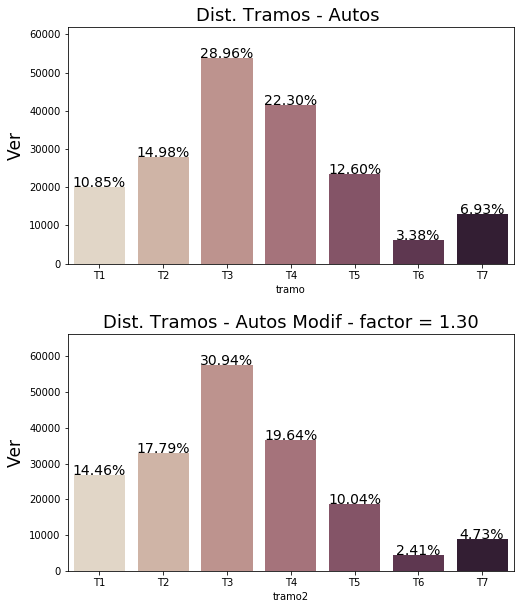

In [71]:
total = len(base_au)
plt.figure(figsize=(8,10))
plt.subplot(211)

g = sb.countplot(x="tramo", data=base_au, palette="ch:.25")
g.set_title('Dist. Tramos - Autos ', fontsize=18)
g.set_ylabel("Ver",fontsize= 17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)


plt.subplot(212)
g2 = sb.countplot(x="tramo2", data=base_au, palette="ch:.25")
g2.set_title('Dist. Tramos - Autos Modif - factor = {:1.2f}'.format(float(correc)), fontsize=18)
g2.set_ylabel("Ver",fontsize= 17)
sizes=[]
for p in g2.patches:
    height = p.get_height()
    sizes.append(height)
    g2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g2.set_ylim(0, max(sizes) * 1.15)


plt.subplots_adjust(hspace = 0.3)

plt.show()

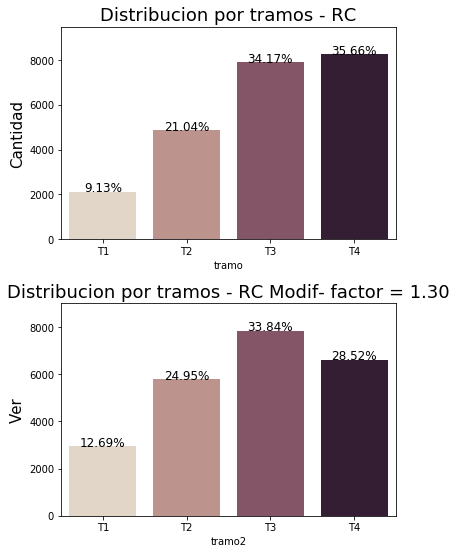

In [72]:
totalr = len(base_rc)
plt.figure(figsize=(6,9))
plt.subplot(211)

gr = sb.countplot(x="tramo", data=base_rc, palette="ch:.25")
gr.set_title('Distribucion por tramos - RC', fontsize=18)
gr.set_ylabel("Cantidad",fontsize= 15)
sizes_rc=[]
for p in gr.patches:
    height_rc = p.get_height()
    sizes_rc.append(height_rc)
    gr.text(p.get_x()+p.get_width()/2.,
            height_rc + 3,
            '{:1.2f}%'.format(height_rc/totalr*100),
            ha="center", fontsize=12) 
gr.set_ylim(0, max(sizes_rc) * 1.15)


plt.subplot(212)
g2r = sb.countplot(x="tramo2", data=base_rc, palette="ch:.25")
g2r.set_title('Distribucion por tramos - RC Modif- factor = {:1.2f}'.format(float(correc)), fontsize=18)
g2r.set_ylabel("Ver",fontsize= 15)
sizes_rc=[]
for p in g2r.patches:
    height_rc = p.get_height()
    sizes_rc.append(height_rc)
    g2r.text(p.get_x()+p.get_width()/2.,
            height_rc + 3,
            '{:1.2f}%'.format(height_rc/totalr*100),
            ha="center", fontsize=12) 
g2r.set_ylim(0, max(sizes_rc) * 1.15)


plt.subplots_adjust(hspace = 0.3)

plt.show()

## Reservas

In [73]:
min_rva_autos = {'T1':(0.7,0), 
                   'T2':(0.45,70000), 
                   'T3':(0.3,112000), 
                   'T4':(0.35,245000), 
                   'T5':(0.25,450000), 
                   'T6':(0.2,750000), 
                   'T7':(1,800000)}

min_rva_rc = {'T1':(0.3,0), 
                   'T2':(0.2,60000), 
                   'T3':(0.125,120000), 
                   'T4':(0.05,250000)}

### Modificación de los mínimos de reserva

In [74]:
min_rva_aut_modif = {k:(v[0],int(v[1]*float(correc))) for k,v in min_rva_autos.items()}
min_rva_rc_modif = {k:(v[0],int(v[1]*float(correc))) for k,v in min_rva_rc.items()}

In [75]:
#Vista de tramos
base_au['mape'] = base_au.tramo.map(min_rva_autos)
base_au['mape_modif'] = base_au.tramo2.map(min_rva_aut_modif)

#Comparables - % de la demanda o mínimo de tramo
base_au['m1'] = base_au.mape.apply(lambda x: x[0]) * base_au['monto_actual']
base_au['m2'] = base_au.mape.apply(lambda x: x[1]) 

#Comparables Corregidos - % de la demanda o mínimo de tramo
base_au['m1_corr'] = base_au.mape_modif.apply(lambda x: x[0]) * base_au['monto_actual']
base_au['m2_corr'] = base_au.mape_modif.apply(lambda x: x[1])

In [76]:
min_rva_aut_modif

{'T1': (0.7, 0),
 'T2': (0.45, 91208),
 'T3': (0.3, 145934),
 'T4': (0.35, 319231),
 'T5': (0.25, 586343),
 'T6': (0.2, 977239),
 'T7': (1, 1042388)}

### Reserva

In [77]:
base_au['rva'] = base_au[['m1','m2']].max(axis=1)
base_au['rva_modif'] = base_au[['m1_corr','m2_corr']].max(axis=1)

In [79]:
(base_au['rva_modif'].sum() / base_au['rva'].sum()) - 1

-0.0728670017733335

In [80]:
base_au.sample(20)

,cia,tipo_d,fecha_demanda,monto_dem,ramo,fecha,factor,monto_actual,tramo,tramo2,mape,mape_modif,m1,m2,m1_corr,m2_corr,rva,rva_modif
84644,163,CL,2009-08-27,233500.000,auto,2009-08-27,4.202,981263.984,T4,T4,"(0.35, 245000)","(0.35, 319231)",343442.395,245000,343442.395,319231,343442.395,343442.395
105547,79,M,2006-07-05,873743.000,auto,2006-07-05,5.261,4597135.798,T7,T6,"(1, 800000)","(0.2, 977239)",4597135.798,800000,919427.160,977239,4597135.798,977239.000
35834,293,L,2016-03-15,62348.000,auto,2016-03-15,1.972,122972.622,T2,T1,"(0.45, 70000)","(0.7, 0)",55337.680,70000,86080.836,0,70000.000,86080.836
97932,352,L,2011-08-04,49931.000,auto,2011-08-04,3.643,181879.252,T2,T2,"(0.45, 70000)","(0.45, 91208)",81845.664,70000,81845.664,91208,81845.664,91208.000
76159,726,L,2018-09-26,589000.000,auto,2018-09-26,1.304,767933.770,T4,T3,"(0.35, 245000)","(0.3, 145934)",268776.819,245000,230380.131,145934,268776.819,230380.131
14731,515,CL,2012-06-06,346955.000,auto,2012-06-06,3.367,1168246.236,T4,T4,"(0.35, 245000)","(0.35, 319231)",408886.182,245000,408886.182,319231,408886.182,408886.182
76695,726,M,2016-08-31,3738652.880,auto,2016-08-31,1.799,6724278.152,T7,T7,"(1, 800000)","(1, 1042388)",6724278.152,800000,6724278.152,1042388,6724278.152,6724278.152
67155,501,CL,2015-08-27,544850.000,auto,2015-08-27,2.180,1187948.708,T4,T4,"(0.35, 245000)","(0.35, 319231)",415782.048,245000,415782.048,319231,415782.048,415782.048
166080,163,CL,2016-06-10,548000.000,auto,2016-06-10,1.875,1027617.150,T4,T4,"(0.35, 245000)","(0.35, 319231)",359666.002,245000,359666.002,319231,359666.002,359666.002
177969,352,L,2013-08-21,123500.000,auto,2013-08-21,2.973,367111.419,T3,T3,"(0.3, 112000)","(0.3, 145934)",110133.426,112000,110133.426,145934,112000.000,145934.000


In [39]:
base_au['rva_modif'].sum()

106152972556.92354

In [40]:
base_au['rva'].sum()

110658281400.13716